# Import

In [51]:
import glob, os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm, trange
import torch.nn.functional as F
import xarray as xr
import dask
from IPython import display

In [52]:
import platform
print(platform.platform())

Linux-5.4.144+-x86_64-with-glibc2.31


In [53]:
device = torch.device("cuda:0")
#device = torch.device("cpu")

# Dataset definitions

In [54]:
keys_to_add_to_sample = ['diff_T_sqr', 'diff_S_sqr', 'diff_TS', 'sosstsst', 'sosaline', 'rho_sa_sa', 'rho_sa_ct', 'rho_ct_ct', \
                         'sigma0_delta']

In [55]:
class SalinityTemperatureDensityDataset(Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, list_of_netcdf_files, select='All', portion_of_time_series=0.5, transform=None, normalize=False):
        self.data = [xr.DataArray() for i in range(len(list_of_netcdf_files))]
        for i, datasetNetcdfFile in enumerate(list_of_netcdf_files) :
            self.data[i] = xr.open_mfdataset(datasetNetcdfFile, parallel=True).load()
            # nan filling
            self.data[i] = self.data[i].bfill(dim='x')
            if (np.isnan(self.data[i]['diff_S_sqr']).any() or np.isnan(self.data[i]['sigma0_delta']).any()) :
                print("NANS in data " + datasetNetcdfFile)
        data_file_len = len(self.data[0]['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*data_file_len), data_file_len)
        self.total_len = len(self.data)*len(time_index_range)
        self.index_table = np.transpose(np.stack([np.concatenate([np.full(len(time_index_range), i) for i in range(len(self.data))]),\
         np.concatenate([time_index_range for i in range(len(self.data))])]))
        self.transform = transform
        self.normalize = normalize
        if (normalize) :
            for i in range(len(list_of_netcdf_files)) :
                for key in self.data[i].data_vars :
                    self.data[i].attrs['mean_'+key] = self.data[i].data_vars[key].mean().compute()
                    self.data[i].attrs['std_'+key] = self.data[i].data_vars[key].std().compute()
        
    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        [index_of_dataset, index_of_time_counter] = self.index_table[idx]
        current_dataframe = self.data[index_of_dataset].isel(time_counter=index_of_time_counter).load()
        
        sample = dict()
        sample['dataset_index'] = index_of_dataset
        sample['dataset_region'] = self.data[index_of_dataset].attrs['region']
        sample['dataset_season'] = self.data[index_of_dataset].attrs['season']
        for key in keys_to_add_to_sample :
            if self.normalize :
                sample[key] = ((current_dataframe[key]-current_dataframe.attrs['mean_'+key])/current_dataframe.attrs['std_'+key]).values
                sample['mean_'+key] = current_dataframe.attrs['mean_'+key].values
                sample['std_'+key] = current_dataframe.attrs['std_'+key].values
            else : 
                sample[key] = current_dataframe[key].values

        if self.transform:
            sample = self.transform(sample)

        return sample

In [56]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample
        for key in keys_to_add_to_sample :
            transformed_sample[key] = torch.from_numpy(sample[key])
        return transformed_sample

# Data Loader

In [57]:
list_of_datasets = sorted(glob.glob('datasets/dataset?.nc'))
#list_of_datasets = ['oceanDataNotebooks/density_ML/datasets/dataset'+str(index)+'.nc' for index in range(4)]

In [58]:
list_of_datasets

['datasets/dataset0.nc',
 'datasets/dataset1.nc',
 'datasets/dataset2.nc',
 'datasets/dataset3.nc',
 'datasets/dataset4.nc',
 'datasets/dataset5.nc']

In [59]:
batch_size = 5

In [62]:
%%time
train_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='First', \
                                                  portion_of_time_series=0.6, transform=ToTensor(), normalize=True)
test_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='Last', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)

CPU times: user 2.15 s, sys: 667 ms, total: 2.82 s
Wall time: 3.77 s


In [63]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [64]:
train_data_iterator = iter(train_data_loader)

In [65]:
test_data_iterator = iter(test_data_loader)

In [66]:
#sample = test_data_iterator.next()

# Fully-connected NN Model

In [67]:
h = 20 # height of images
w = 20 # width of images

In [68]:
keys_input_FCNN = {'diff_S_sqr', 'diff_TS', 'diff_T_sqr', 'rho_sa_sa', 'rho_sa_ct', 'rho_ct_ct'}
keys_targets_FCNN = {'sigma0_delta'}

In [69]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(len(keys_input_FCNN), 8)
        self.lin2 = nn.Linear(8, 16)
        self.lin3 = nn.Linear(16, 8)
        self.lin4 = nn.Linear(8, len(keys_targets_FCNN))

    def forward(self, x):
        #flatten_input = nn.Flatten(x)
        res = self.lin1(x)
        res = F.relu(res)
        res = self.lin2(res)
        res = F.relu(res)
        res = self.lin3(res)
        res = F.relu(res)
        res = self.lin4(res)
        return res

## Training

In [75]:
# Instantiate model  
modelFCNN = (FCNN()).to(device)

In [76]:
print(modelFCNN)

FCNN(
  (lin1): Linear(in_features=6, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=8, bias=True)
  (lin4): Linear(in_features=8, out_features=1, bias=True)
)


In [77]:
# Loss and Optimizer
criterion = nn.MSELoss()  
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(modelFCNN.parameters(), lr=0.001)

Transform inputs and targets (treatment pixel by pixel) :

In [78]:
def transform_input(sample) :
    return torch.hstack([sample[key].view(-1,1) for key in keys_input_FCNN]).to(torch.float32).to(device)
def transform_target(sample) : 
    return sample['sigma0_delta'].view(-1, 1).to(torch.float32).to(device)

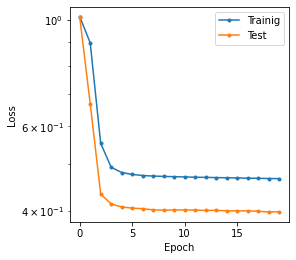

CPU times: user 39min 37s, sys: 22.8 s, total: 40min
Wall time: 39min 37s


In [79]:
%%time
nb_of_epochs = 20

epoch_training_losses = np.empty(nb_of_epochs)
epoch_test_losses = np.empty(nb_of_epochs)

# Iterate through train set minibatchs
for epoch in tqdm(range(nb_of_epochs)):  
    print('Epoch ' + str(epoch))
    # Train
    training_losses = list()
    for sample in tqdm(train_data_loader, desc='Training', ascii=True):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = transform_input(sample)
        #if not(x.isnan().any()) : 
        y = modelFCNN(x)
        loss = criterion(y, transform_target(sample))
        # Backward pass
        loss.backward()
        optimizer.step()
        training_losses = np.append(training_losses, loss.detach().cpu().numpy())
    epoch_training_losses[epoch] = np.mean(training_losses)
    # Test
    with torch.no_grad():
        test_losses = list()
        for sample in tqdm(test_data_loader, desc='Testing', ascii=True):
            # Forward pass
            x = transform_input(sample)
            y = modelFCNN(x)

            loss = criterion(y, transform_target(sample))
            test_losses = np.append(test_losses, loss.detach().cpu().numpy())
        epoch_test_losses[epoch] = np.mean(test_losses)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3.5), constrained_layout=True)
    
    ax.plot(epoch_training_losses[0:epoch+1], '.-', label='Trainig')
    ax.plot(epoch_test_losses[0:epoch+1], '.-', label='Test')
    ax.set(yscale='log', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.show()

# Convolutional NN model

In [80]:
keys_input_CNN = {'sosstsst', 'rho_ct_ct'}
keys_targets_CNN = {'sigma0_delta'}

In [81]:
import torch.nn as nn

class first_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(len(keys_input_CNN), 32, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, len(keys_targets_CNN), kernel_size=3, padding='same', padding_mode='replicate')
        #self.batch_norm1 = nn.BatchNorm2d(32)
        #self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.batch_norm1(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 4 
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 5 
        x = self.conv5(x)
        
        return x        

## Training

In [82]:
# Instantiate model  
modelCNN = (first_CNN().double()).to(device)

In [83]:
print(modelCNN)

first_CNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
)


In [84]:
def transform_input_CNN(sample) :
    return torch.transpose(torch.stack([sample[key] for key in keys_input_CNN]), 0, 1).to(device)
def transform_target_CNN(sample) : 
    return sample['sigma0_delta'].view(batch_size, 1, h, w).to(device)

In [85]:
# Loss and Optimizer
criterion = nn.MSELoss()  # softmax is already here!
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

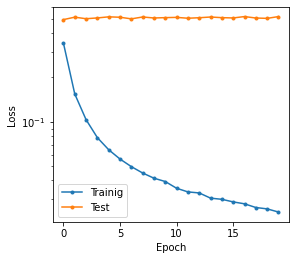

CPU times: user 54min 45s, sys: 23.6 s, total: 55min 9s
Wall time: 54min 49s


In [86]:
%%time
nb_of_epochs = 20

epoch_training_losses = np.empty(nb_of_epochs)
epoch_test_losses = np.empty(nb_of_epochs)

# Iterate through train set minibatchs
for epoch in tqdm(range(nb_of_epochs)):  
    print('Epoch ' + str(epoch))
    # Train
    training_losses = list()
    for sample in tqdm(train_data_loader, desc='Training', ascii=True):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = transform_input_CNN(sample)
        y = modelCNN(x)
        loss = criterion(y, transform_target_CNN(sample))
        # Backward pass
        loss.backward()
        optimizer.step()
        training_losses = np.append(training_losses, loss.detach().cpu().numpy())
    epoch_training_losses[epoch] = np.mean(training_losses)
    # Test
    with torch.no_grad():
        test_losses = list()
        for sample in tqdm(test_data_loader, desc='Testing', ascii=True):
            # Forward pass
            x = transform_input_CNN(sample)
            y = modelCNN(x)

            loss = criterion(y, transform_target_CNN(sample))
            test_losses = np.append(test_losses, loss.detach().cpu().numpy())
        epoch_test_losses[epoch] = np.mean(test_losses)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3.5), constrained_layout=True)
    
    ax.plot(epoch_training_losses[0:epoch+1], '.-', label='Trainig')
    ax.plot(epoch_test_losses[0:epoch+1], '.-', label='Test')
    ax.set(yscale='log', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.show()

# Compare results

Deterministic parametrization:

In [87]:
def determ_param(diff_T_sqr, deriv_rho_TT, c) :
    return 0.5*c*deriv_rho_TT*diff_T_sqr

In [88]:
def restore_units(sample, data, variable, index_in_batch=0) :
    return (sample['std_'+variable][index_in_batch]*data[index_in_batch]+sample['mean_'+variable][index_in_batch])
def normalize(sample, data, variable, index_in_batch=0) :
    return (data[index_in_batch]-sample['mean_'+variable][index_in_batch])/(sample['std_'+variable][index_in_batch])

In [89]:
coef_determ_param = 0.1

In [97]:
sample = test_data_iterator.next()
index_in_batch = 1

snapshot = dict()
snapshot['true_error'] = np.squeeze(restore_units(sample,sample['sigma0_delta'],'sigma0_delta',index_in_batch).numpy())
snapshot['FCNN'] = restore_units(sample, modelFCNN(transform_input(sample)).view(batch_size,w,h),'sigma0_delta',index_in_batch).detach().cpu().numpy()
snapshot['CNN'] = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(batch_size,w,h),'sigma0_delta',index_in_batch).detach().cpu().numpy()
snapshot['determ_param'] = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',index_in_batch), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',index_in_batch), \
                                        coef_determ_param).numpy()

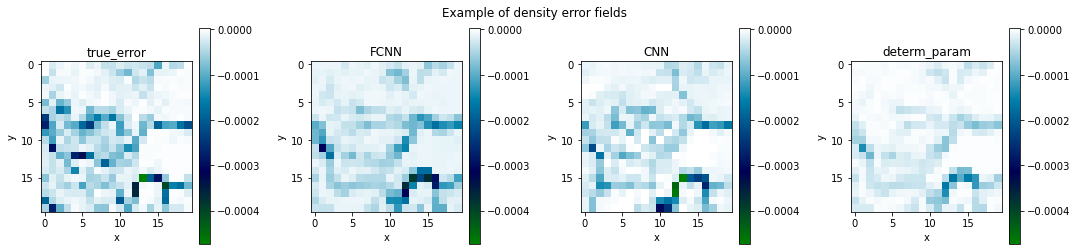

In [98]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields')
for i, key in enumerate(snapshot.keys()) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

# Evaluation

## Total MSE on a dataset

In [92]:
eval_loss = nn.MSELoss(reduction='none') 

In [93]:
MSE = dict({'determ_param': [], 'FCNN': []})
MSE['determ_param'] = [ list() for i in range(len(list_of_datasets))]
MSE['FCNN' ] = [ list() for i in range(len(list_of_datasets))]
MSE['CNN' ] = [ list() for i in range(len(list_of_datasets))]
labels = ['' for i in range(len(list_of_datasets))]

In [94]:
%%time
for i in range(len(list_of_datasets)) :
    single_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = [list_of_datasets[i]], select='Last', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)
    eval_data_loader = DataLoader(dataset=single_dataset, batch_size=1, shuffle=False)
    current_list_FCNN = []; current_list_CNN = []; current_list_param = []
    for j, sample in enumerate(eval_data_loader) :
        true_error = restore_units(sample,sample['sigma0_delta'],'sigma0_delta',0).view(-1,1).to(device)
        FCNN_error = restore_units(sample, modelFCNN(transform_input(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1).to(device)
        CNN_error = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1).to(device)
        determ_param_error = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',0), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',0), \
                                        coef_determ_param).view(-1,1).to(device)
        current_list_FCNN = current_list_FCNN + list(np.squeeze(eval_loss(FCNN_error, true_error).detach().cpu().numpy()))
        current_list_CNN = current_list_CNN + list(np.squeeze(eval_loss(CNN_error, true_error).detach().cpu().numpy()))
        current_list_param = current_list_param + list(np.squeeze(eval_loss(determ_param_error, true_error).detach().cpu().numpy()))
    MSE['FCNN'][i] = current_list_FCNN
    MSE['CNN'][i] = current_list_CNN
    MSE['determ_param'][i] = current_list_param
    labels[i] = 'Reg ' + sample['dataset_region'][0] + ' ' + sample['dataset_season'][0]

CPU times: user 48.3 s, sys: 491 ms, total: 48.8 s
Wall time: 49.4 s


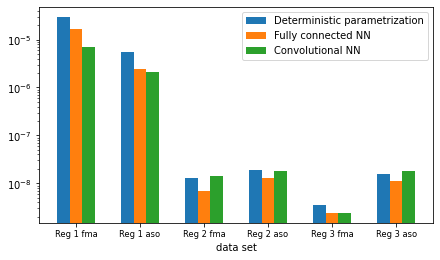

In [99]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(list_of_datasets))
bar_width = 0.2

for i, key in enumerate(['determ_param', 'FCNN', 'CNN']) :
    ax.bar(x+i*bar_width, [np.mean(MSE[key][region]) for region in range(len(list_of_datasets))], width=bar_width, label=key)
ax.legend(['Deterministic parametrization', 'Fully connected NN', 'Convolutional NN'])
ax.set_xticks(x+bar_width)
#ax.axhline(y=1., color='k')
ax.set_xticklabels(labels,fontsize=10)
ax.set_xlabel('data set')
ax.xaxis.set_tick_params(labelsize='small')
ax.set(yscale='log')
plt.show()

## Histograms of MSE

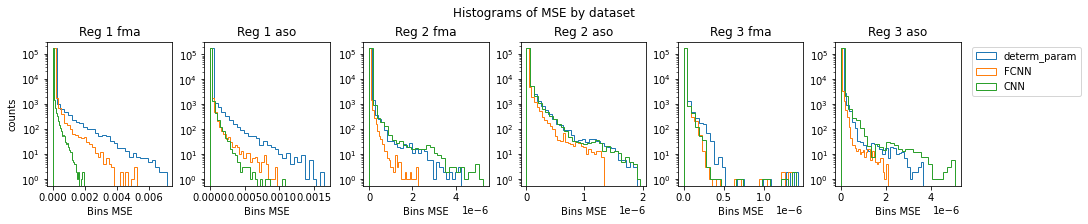

In [96]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
fig.suptitle('Histograms of MSE by dataset')
for key in ['determ_param', 'FCNN', 'CNN'] :
    for i in range(len(list_of_datasets)) :
        ax[i].hist(MSE[key][i], bins=30, histtype='step', density=False, label=key)
        ax[i].set(yscale='log', title=labels[i], xlabel='Bins MSE')
ax[0].set(ylabel='counts')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()